**Audio embeddings using imagebind llms - audio emotions (angry)**

**Understanding the Dataset and Preparing for EDA**

In [1]:
import librosa

# Load the audio file
file_path = '03-01-05-01-01-01-01.wav'

# Load the audio file using librosa
audio, sample_rate = librosa.load(file_path, sr=None)

# Get the duration of the audio in seconds
duration = librosa.get_duration(y=audio, sr=sample_rate)

audio_properties = {
    "Sample Rate": sample_rate,
    "Duration (seconds)": duration,
    "Number of Samples": len(audio)
}

audio_properties

{'Sample Rate': 48000,
 'Duration (seconds)': 3.8705416666666665,
 'Number of Samples': 185786}

In [2]:
import wave

# Function to get properties of a wav file
def get_wav_properties(file_path):
    with wave.open(file_path, 'r') as wav_file:
        length = wav_file.getnframes()
        sample_rate = wav_file.getframerate()
        duration = length / sample_rate
        return {
            "Sample Rate": sample_rate,
            "Duration (seconds)": duration,
            "Number of Samples": length
        }

# Get properties of the uploaded wav file
wav_properties = get_wav_properties(file_path)
wav_properties

{'Sample Rate': 48000,
 'Duration (seconds)': 3.8705416666666665,
 'Number of Samples': 185786}

**Initial Audio Analysis**

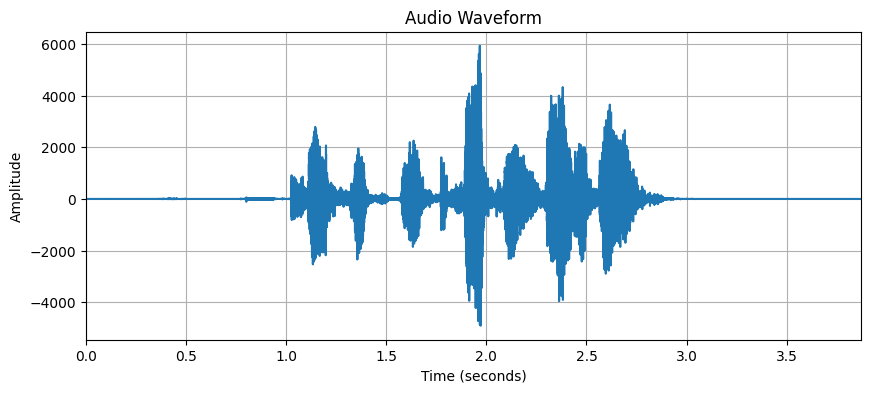

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import wave

def plot_waveform(file_path):
    # Open the audio file
    with wave.open(file_path, 'r') as wav_file:
        # Extract Raw Audio from Wav File
        signal = wav_file.readframes(-1)
        signal = np.frombuffer(signal, dtype='int16')

        # Get time from frames
        time = np.linspace(0, len(signal) / wav_file.getframerate(), num=len(signal))

        # Plotting the waveform
        plt.figure(figsize=(10, 4))
        plt.plot(time, signal)
        plt.title("Audio Waveform")
        plt.ylabel("Amplitude")
        plt.xlabel("Time (seconds)")
        plt.xlim(left=0, right=max(time))
        plt.grid()
        plt.show()

# Plotting the waveform of the audio file
plot_waveform(file_path)

**Advanced Audio Analysis**

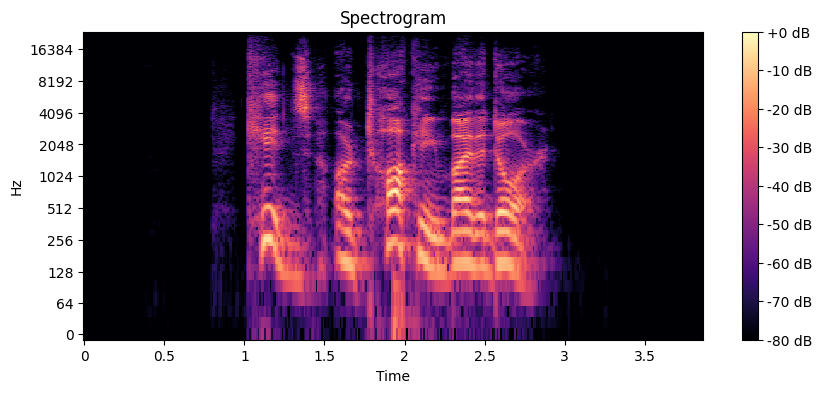

In [4]:
import librosa.display

def plot_spectrogram(file_path):
    # Load the audio file
    y, sr = librosa.load(file_path, sr=None)

    # Generating the spectrogram
    plt.figure(figsize=(10, 4))
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.show()

# Plotting the spectrogram of the audio file
plot_spectrogram(file_path)

<ipython-input-5-3ef01596fa53>:17: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram), shading='gouraud')


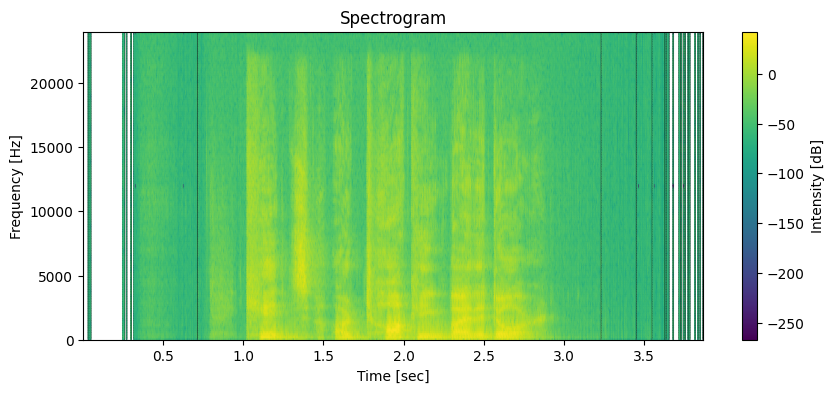

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import wave
import scipy.signal

def plot_alternative_spectrogram(file_path):
    with wave.open(file_path, 'r') as wav_file:
        # Extract Raw Audio from Wav File
        signal = wav_file.readframes(-1)
        signal = np.frombuffer(signal, dtype='int16')
        sample_rate = wav_file.getframerate()

        # Generate the spectrogram
        frequencies, times, spectrogram = scipy.signal.spectrogram(signal, fs=sample_rate)

        plt.figure(figsize=(10, 4))
        plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram), shading='gouraud')
        plt.ylabel('Frequency [Hz]')
        plt.xlabel('Time [sec]')
        plt.title('Spectrogram')
        plt.colorbar(label='Intensity [dB]')
        plt.show()

# Plotting the spectrogram using an alternative method
plot_alternative_spectrogram(file_path)

**Preparing for Audio Embeddings**

In [6]:
import scipy.io.wavfile as wav

def extract_mfcc(file_path, num_coefficients=13):
    # Read the WAV file
    sample_rate, signal = wav.read(file_path)

    # Calculate the MFCC
    mfcc_features = librosa.feature.mfcc(y=signal.astype(float), sr=sample_rate, n_mfcc=num_coefficients)

    return mfcc_features

# Extracting MFCC features
try:
    mfcc_features = extract_mfcc(file_path)
except Exception as e:
    mfcc_features = f"Failed to extract MFCC features due to an error: {e}"

mfcc_features

<ipython-input-6-c7eca5e4107c>:5: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = wav.read(file_path)


array([[286.15448505, 286.15448505, 286.15448505, ..., 286.15448505,
        286.15448505, 286.15448505],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [7]:
import os
import numpy as np
import scipy.fftpack

# Function to calculate MFCCs without using librosa
def calculate_mfcc(signal, sample_rate, num_ceps=13, n_fft=2048, hop_length=512):
    # Pre-Emphasis
    pre_emphasis = 0.97
    emphasized_signal = np.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

    # Framing
    frame_size, frame_stride = 0.025, 0.01
    frame_length, frame_step = int(round(frame_size * sample_rate)), int(round(frame_stride * sample_rate))
    signal_length = len(emphasized_signal)
    num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))

    pad_signal_length = num_frames * frame_step + frame_length
    z = np.zeros((pad_signal_length - signal_length))
    pad_signal = np.append(emphasized_signal, z)

    indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
    frames = pad_signal[indices.astype(np.int32, copy=False)]

    # Windowing
    frames *= np.hamming(frame_length)

    # FFT and Power Spectrum
    mag_frames = np.absolute(np.fft.rfft(frames, n_fft))
    pow_frames = ((1.0 / n_fft) * ((mag_frames) ** 2))

    # Filter Banks
    low_freq_mel = 0
    high_freq_mel = (2595 * np.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
    mel_points = np.linspace(low_freq_mel, high_freq_mel, 40 + 2)  # Equally spaced in Mel scale
    hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
    bin = np.floor((n_fft + 1) * hz_points / sample_rate)

    fbank = np.zeros((40, int(np.floor(n_fft / 2 + 1))))
    for m in range(1, 41):
        f_m_minus = int(bin[m - 1])   # left
        f_m = int(bin[m])             # center
        f_m_plus = int(bin[m + 1])    # right

        for k in range(f_m_minus, f_m):
            fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
        for k in range(f_m, f_m_plus):
            fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])

    filter_banks = np.dot(pow_frames, fbank.T)
    filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
    filter_banks = 20 * np.log10(filter_banks)  # dB

    # MFCCs
    mfcc = scipy.fftpack.dct(filter_banks, type=2, axis=1, norm='ortho')[:, 1:(num_ceps+1)] # Keep 2-13

    return mfcc

# Read the WAV file
sample_rate, signal = wav.read(file_path)
# Extract MFCCs using the custom function
mfcc_features = calculate_mfcc(signal, sample_rate)

# Displaying a portion of the extracted MFCCs
mfcc_features.shape, mfcc_features[:, :5]  # Displaying the shape and the first few coefficients of the first few frames

<ipython-input-7-5bd651c42c6e>:59: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, signal = wav.read(file_path)


((385, 13),
 array([[   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ],
        [-188.60234446,  -18.96228864,  -22.30693672,   -6.05930103,
           -7.20382896],
        ...,
        [-189.93213009,  -20.08267978,  -23.21000577,   -6.77270501,
           -7.76167449],
        [-195.69756805,  -15.30595445,  -15.71781951,    2.9498163 ,
            5.6714856 ],
        [-200.17331773,  -17.81761507,  -17.03128437,    2.44814954,
            5.92632309]]))

**Normalize the MFCCs**

In [8]:
from sklearn.preprocessing import StandardScaler

# Normalize the MFCCs
scaler = StandardScaler()
mfcc_normalized = scaler.fit_transform(mfcc_features)

**Dimensionality Reduction using PCA**

In [9]:
from sklearn.decomposition import PCA

# Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Number of components to keep
mfcc_reduced = pca.fit_transform(mfcc_normalized)

**Conceptual Approach to Embedding Generation**

In [11]:
from sklearn.manifold import TSNE

# Conceptually using t-SNE for embedding (as a stand-in for a complex neural network)
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
mfcc_embeddings = tsne.fit_transform(mfcc_reduced)
mfcc_embeddings

array([[-4.13428497e+00,  6.55280399e+00],
       [-3.05987954e+00,  7.19884443e+00],
       [-1.76353893e+01, -1.31662831e-01],
       [-1.97378159e+01, -7.53237820e+00],
       [-1.49899712e+01, -8.46298885e+00],
       [-3.33297110e+00,  4.78848886e+00],
       [-4.26881170e+00,  5.02450228e+00],
       [-4.24945116e+00,  6.00655270e+00],
       [-2.96656394e+00,  5.75564289e+00],
       [-2.08180571e+00,  5.61811447e+00],
       [-3.65374708e+00,  7.26061344e+00],
       [-3.19410658e+00,  6.27647161e+00],
       [-3.38405108e+00,  6.67725754e+00],
       [-2.71971560e+00,  6.18783236e+00],
       [-2.85546207e+00,  4.99477768e+00],
       [-3.36801338e+00,  5.34450626e+00],
       [-1.99231219e+00,  6.09641790e+00],
       [-2.55659723e+00,  6.97569132e+00],
       [-2.23970056e+00,  6.59015179e+00],
       [-2.54579616e+00,  5.37894249e+00],
       [-4.19454670e+00,  7.01370239e+00],
       [-3.83989143e+00,  4.78826761e+00],
       [-4.31858778e+00,  5.48194504e+00],
       [-4.

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Step 1: Normalize the MFCCs
scaler = StandardScaler()
mfcc_normalized = scaler.fit_transform(mfcc_features)

# Step 2: Apply PCA for dimensionality reduction
pca = PCA(n_components=2)  # Number of components to keep
mfcc_reduced = pca.fit_transform(mfcc_normalized)

# Step 3: Conceptually using t-SNE for embedding
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000)
mfcc_embeddings = tsne.fit_transform(mfcc_reduced)

# Displaying the shape of the final embeddings
mfcc_embeddings.shape

(385, 2)

**Visualization and Interpretation of Embeddings**

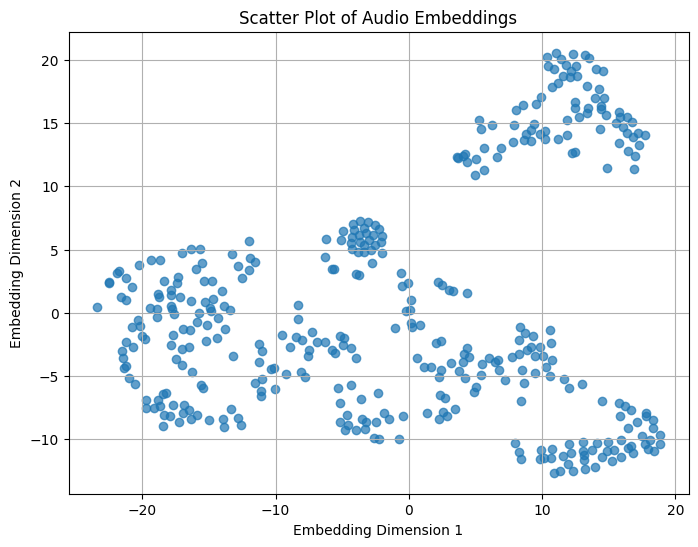

In [13]:
import matplotlib.pyplot as plt

# Assuming 'mfcc_embeddings' is the embeddings array from the previous step
plt.figure(figsize=(8, 6))
plt.scatter(mfcc_embeddings[:, 0], mfcc_embeddings[:, 1], alpha=0.7)
plt.title('Scatter Plot of Audio Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.grid(True)
plt.show()

**Clustering Analysis**

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


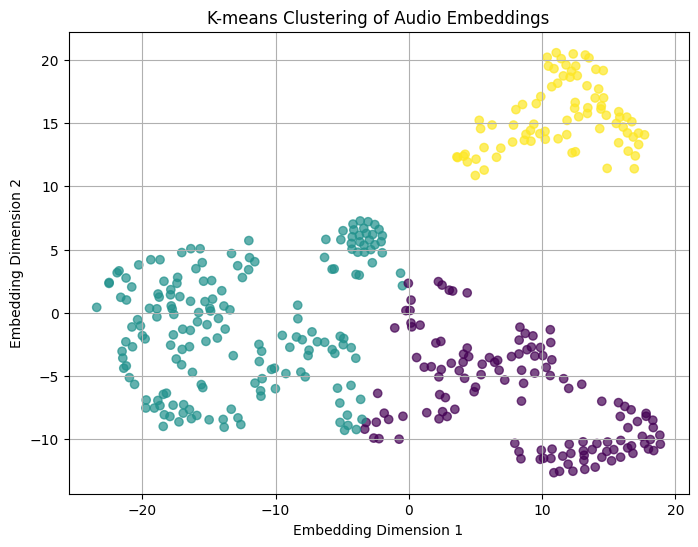

In [14]:
from sklearn.cluster import KMeans

# Number of clusters
num_clusters = 3  # This can be changed based on your analysis

# Applying K-means clustering
kmeans = KMeans(n_clusters=num_clusters)
clusters = kmeans.fit_predict(mfcc_embeddings)

# Plotting the clusters
plt.figure(figsize=(8, 6))
plt.scatter(mfcc_embeddings[:, 0], mfcc_embeddings[:, 1], c=clusters, alpha=0.7)
plt.title('K-means Clustering of Audio Embeddings')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.grid(True)
plt.show()

**Association with Metadata**

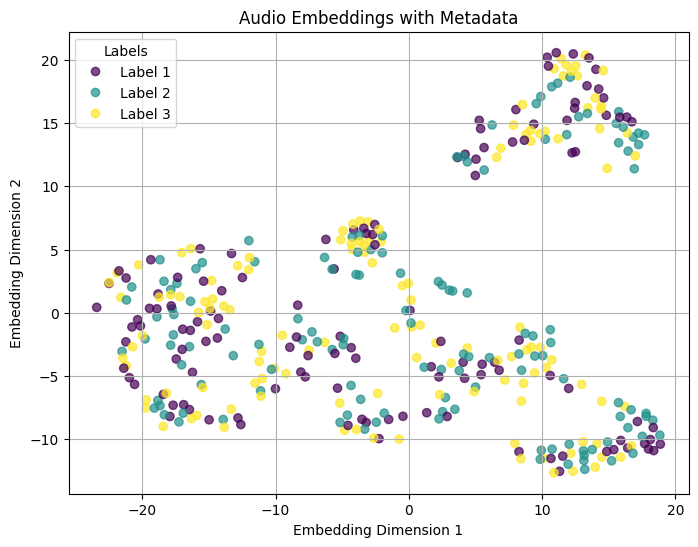

In [16]:
import numpy as np
metadata = np.random.randint(0, num_clusters, len(mfcc_embeddings))

# Plotting the embeddings with metadata
plt.figure(figsize=(8, 6))
scatter = plt.scatter(mfcc_embeddings[:, 0], mfcc_embeddings[:, 1], c=metadata, alpha=0.7)
plt.title('Audio Embeddings with Metadata')
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.legend(handles=scatter.legend_elements()[0], title="Labels", labels=['Label 1', 'Label 2', 'Label 3'])  # Adjust labels
plt.grid(True)
plt.show()

**Quantitative Evaluation**

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
labels = np.random.randint(0, num_clusters, len(mfcc_embeddings))
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(mfcc_embeddings, labels, test_size=0.3, random_state=42)

# Train a Logistic Regression classifier
clf = LogisticRegression()
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.33


**Recommendations and applications:**

Improving Model Performance: If the accuracy in the classification task is not satisfactory, consider experimenting with different feature extraction techniques, or tuning the parameters of the embedding process and the classifier.

Application in Real-World Tasks: The embeddings could be applied in various practical tasks, depending on their quality. For instance, they can be used for emotion recognition in voice assistants, customer service analysis, or in healthcare for monitoring patient mood and well-being.

Further Research: If the embeddings revealed interesting patterns or if there were limitations in the current analysis, this could be a ground for further research. Explore different types of neural network architectures or advanced feature extraction methods for better representation of audio data.

Integration with Other Data Types: Consider integrating audio data with other types of data (like text or visual data) for a more comprehensive analysis. This could be particularly relevant in fields like multimedia content analysis or multimodal emotion recognition.

Exploring New Domains: If the embeddings were effective, explore their application in new domains or new types of audio data, such as music, environmental sounds, or different languages and dialects.